# Workshop - Transformers 101

## Introdução

O seguinte notebook é derivado desse [blog post](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), com modificações para as últimas versões de Keras e PyTorch.

### Contexto

A aprendizagem por transferência, especialmente modelos como ELMO da Allen AI, Open-GPT da OpenAI e BERT do Google, permitiu que os pesquisadores batessem vários benchmarks com o mínimo de ajuste específico da tarefa e forneceram ao resto da comunidade de PNL modelos pré-treinados que poderiam facilmente (com menos dados e menos tempo de computação) ser ajustados e implementados para produzir resultados de última geração. Infelizmente, para muitos que estão começando no PLN e até mesmo para alguns praticantes experientes, a teoria e a aplicação prática desses modelos poderosos ainda não são bem compreendidas.

### O que é o BERT?

BERT (Bidirectional Encoder Representations from Transformers), lançado no final de 2018, é o modelo que usaremos neste tutorial para fornecer aos participantes uma melhor compreensão e orientação prática para o uso de modelos de aprendizagem por transferência em PLN. BERT é um método de pré-treinamento de representações de linguagem que foi usado para criar modelos que os praticantes de PLN podem baixar e usar gratuitamente. Você pode usar esses modelos para extrair recursos de linguagem de alta qualidade de seus dados de texto ou pode ajustar esses modelos em uma tarefa específica (classificação, reconhecimento de entidade, resposta a perguntas, etc.) com seus próprios dados para produzir o estado da arte em predições.

### Como BERT (ainda) pode me ajudar?

Este notebook (como parte de um workshop hands on) explicará como você pode modificar e ajustar o BERT para criar um modelo de PLN poderoso que fornece rapidamente resultados de última geração.

### Por que fazer o fine-tuning em vez de construir meu próprio modelo?

Neste tutorial, usaremos BERT para treinar um classificador de texto. Especificamente, nos utilizaremos do modelo BERT pré-treinado, adicionaremos uma camada não treinada de neurônios no final (basicamente adaptando o modelo para um sistema decisório) e treinaremos o novo modelo para nossa tarefa de classificação. Por que fazer isso em vez de treinar um modelo específico de aprendizado profundo (como uma CNN, BiLSTM, etc.) que seja adequado para a tarefa específica de PLN que você precisa?

#### Treinamento Facilitado

Primeiro, os pesos do modelo BERT pré-treinados já codificam muitas informações sobre nossa linguagem. Como resultado, leva muito menos tempo para treinar nosso modelo ajustado - é como se já tivéssemos treinado extensivamente as camadas inferiores de nossa rede e só precisássemos ajustá-las suavemente enquanto usamos sua saída como recursos para nossa tarefa de classificação. Na verdade, os autores recomendam apenas 2 a 4 épocas de treinamento para ajustar o BERT em uma tarefa específica de PNL (em comparação com as centenas de horas de GPU necessárias para treinar o modelo BERT original ou um LSTM do zero!).

#### Menos Dados

Além disso, e talvez tão importante, devido aos pesos pré-treinados, este método nos permite ajustar nossa tarefa em um conjunto de dados muito menor do que seria necessário em um modelo construído do zero. Uma grande desvantagem dos modelos de PLN construídos do zero é que muitas vezes precisamos de um conjunto de dados proibitivamente grande para treinar nossa rede com uma precisão razoável, o que significa que muito tempo e energia tiveram que ser investidos na criação do conjunto de dados. Ao ajustar o BERT, agora podemos treinar um modelo para um bom desempenho em uma quantidade muito menor de dados de treinamento.

#### Bons Resultados

Em segundo lugar, este procedimento simples de fine-tuning (normalmente adicionando uma camada totalmente conectada no topo do BERT e treinando por algumas épocas) demonstrou alcançar resultados de última geração com ajustes mínimos específicos para uma ampla variedade de tarefas tais como classificação , inferência de linguagem, busca por semelhança semântica, resposta a perguntas (Q&A), etc. Em vez de implementar arquiteturas personalizadas e às vezes obscuras que funcionam bem em uma tarefa específica, simplesmente ajustar o BERT mostra-se uma alternativa melhor (ou pelo menos igual).

#### Uma Mudança no Paradigma em PLN

Essa mudança para o uso de Transferência de Aprendizagem é paralela à mesma mudança que ocorreu na Visão Computacional há alguns anos. Por exemplo, criar uma boa rede de aprendizado profundo para tarefas de visão computacional pode exigir milhões de parâmetros e ser muito caro para treinar. Pesquisadores então descobriram que as redes profundas aprendem representações hierárquicas de recursos (recursos simples, como bordas nas camadas mais baixas, com recursos gradualmente mais complexos nas camadas superiores).

Em vez de treinar uma nova rede do zero a cada vez, as camadas inferiores de uma rede treinada com recursos de imagem generalizados poderiam ser copiadas e transferidas para uso em outra rede com uma tarefa diferente. Logo, se tornou uma prática comum baixar uma rede profunda pré-treinada e treiná-la rapidamente para a nova tarefa ou adicionar camadas adicionais no topo - muito preferível ao caro processo de treinar uma rede do zero. Para muitos, a introdução de modelos de linguagem pré-treinados profundos em 2018 (ELMO, BERT, ULMFIT, Open-GPT, etc.) sinaliza a mesma mudança para transferência de aprendizagem em PNL que a visão computacional viu.

Vamos lá!

## Instalação e Imports

A seguir, vamos instalar a interface pytorch para BERT da Hugging Face. (Esta biblioteca contém interfaces para outros modelos de linguagem pré-treinados, como os GPT da OpenAI.) Selecionamos a interface pytorch porque ela atinge um bom equilíbrio entre as APIs de alto nível (que são fáceis de usar, mas não fornecem insights sobre como as coisas funcionam) e código tensorflow (que contém muitos detalhes, mas muitas vezes nos desvia para lições sobre tensorflow, quando o objetivo aqui é falar sobre Transformers!).

No momento, a biblioteca Hugging Face parece ser a interface pytorch mais amplamente aceita e poderosa para trabalhar com BERT e outros modelos. Além de suportar uma variedade de diferentes modelos de linguagem pré-treinados (e modelos futuros que virão - em breve devo ter material comparativo entre BERT, GPT-4 e Gemma), a biblioteca também inclui modificações pré-construídas do BERT adequadas à sua tarefa específica. Por exemplo, neste tutorial usaremos BertForSequenceClassification (https://huggingface.co/docs/transformers/v4.39.1/en/model_doc/bert#transformers.BertForSequenceClassification), mas a biblioteca também inclui modificações de BERT projetadas para classificação de token, resposta a perguntas, previsão da próxima frase, etc.

In [1]:
!pip install pytorch-pretrained-bert pytorch-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

Para que o torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo.

Posteriormente, em nosso ciclo de treinamento, carregaremos os dados no dispositivo.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

## Carregando o Dataset


Usaremos o conjunto de dados [crítica de filme do IMDB](http://ai.stanford.edu/~amaas/data/sentiment/).

Este é um conjunto de dados para classificação de sentimento binário contendo substancialmente mais dados do que conjuntos de dados de referência anteriores. Fornecemos um conjunto de 25.000 resenhas de filmes altamente polares para treinamento e 25.000 para teste. Também existem dados adicionais não rotulados para uso. São fornecidos formatos de texto bruto e pacote de palavras já processado. Consulte o arquivo README contido na versão para obter mais detalhes.

**Coluna 1**: rótulo de sentimento binário

**Coluna 2**: A crítica do filme

[Aqui](http://nlpprogress.com/english/sentiment_análise.html) você pode ver que BERT é praticamente SOTA (embora não muito) para este conjunto de dados


In [5]:
from torchnlp.datasets import imdb_dataset

In [6]:
train = imdb_dataset(train=True)

aclImdb_v1.tar.gz: 84.1MB [00:30, 2.73MB/s]                            


In [7]:
train[0]

{'text': "Hickory Dickory Dock was a good Poirot mystery. I confess I have not read the book, despite being an avid Agatha Christie fan. The adaptation isn't without its problems, there were times when the humour, and there were valiant attempts to get it right, was a little overdone, and the events leading up to the final solution were rather rushed. I also thought there were some slow moments so some of the mystery felt padded. However, I loved how Hickory Dickory Dock was filmed, it had a very similar visual style to the brilliant ABC Murders, and it really set the atmosphere, what with the dark camera work and dark lighting. The darker moments were somewhat creepy, this was helped by one of the most haunting music scores in a Poirot adaptation, maybe not as disturbing as the one in One Two Buckle My Shoe, which gave me nightmares. The plot is complex, with all the essential ingredients, though not as convoluted as Buckle My Shoe,and in some way that is a good thing. The acting was 

In [8]:
df = pd.DataFrame.from_records(map(lambda x: (x['sentiment'], x['text']),train), columns=['sentiment', 'text']).sample(4000)

In [9]:
display(df.shape)
display(df.head())
display(df.sentiment.value_counts())

(4000, 2)

,sentiment,text
20661,neg,"Well, I can once and for all put an end to the..."
10757,pos,<br /><br />Robot jox is a great little film o...
21998,neg,The Fluffer may have strong elements of porn i...
3634,pos,This film is a lyrical and romantic memoir tol...
3879,pos,The scenes are fast-paced. the characters are ...


neg    2003
pos    1997
Name: sentiment, dtype: int64

In [10]:
df['sentiment'] = df.sentiment.map({'pos':1,'neg':0})

In [11]:
# Create sentence and label lists
sentences = df.text.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.sentiment.values

## Inputs

A seguir, importe o tokenizer BERT, usado para converter nosso texto em tokens que correspondam ao vocabulário do BERT.

In [12]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 256

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_and_trim(sent):
  tokens = tokenizer.tokenize(sent)
  return tokens[:MAX_LEN - 1] + [tokens[-1]]

tokenized_texts = [tokenize_and_trim(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 356823.78B/s]


Tokenize the first sentence:
['[CLS]', 'well', ',', 'i', 'can', 'once', 'and', 'for', 'all', 'put', 'an', 'end', 'to', 'the', 'question', ':', "'", 'what', 'is', 'the', 'worst', 'movie', 'ever', 'made', '.', '.', '.', 'ever', '?', "'", 'it', 'is', 'flight', 'of', 'fury', ',', 'starring', 'and', 'co', '-', 'written', 'by', 'steven', 'sea', '##gal', '.', 'sure', 'there', 'are', 'lots', 'of', 'famously', 'bad', 'movies', ',', 'but', 'this', 'one', 'takes', 'the', 'cake', 'in', 'that', 'it', 'takes', 'itself', 'so', 'seriously', '.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'it', 'is', 'a', 'romanian', '-', 'made', 'film', 'that', 'speaks', 'to', 'just', 'how', 'far', 'romania', 'has', 'to', 'go', 'to', 'catch', 'up', 'with', 'bollywood', '.', 'it', 'also', 'speaks', 'to', 'just', 'how', 'utterly', 'devoid', 'of', 'intellect', 'and', 'talent', 'steven', 'sea', '##gal', 'has', 'become', '.', 'this', 'movie', 'is', 'so', 'bad', 'that', 'you', 'literally', 'feel', 'violated', 'after', 'watch

O BERT requer entradas formatadas especificamente. Para cada frase de entrada tokenizada, precisamos criar:

- **IDs de entrada**: uma sequência de números inteiros que identifica cada token de entrada com seu número de índice no vocabulário do tokenizer BERT
- **máscara de segmento**: (opcional) uma sequência de 1s e 0s usada para identificar se a entrada tem uma ou duas sentenças. Para entradas de uma frase, isso é simplesmente uma sequência de 0s. Para entradas de duas frases, há um 0 para cada token da primeira frase, seguido por 1 para cada token da segunda frase
- **máscara de atenção**: (opcional) uma sequência de 1s e 0s, com 1s para todos os tokens de entrada e 0s para todos os tokens de preenchimento (detalharemos isso no próximo parágrafo)
- **rótulos**: um valor único de 1 ou 0. Em nossa tarefa 1 significa "gramatical" e 0 significa "não gramatical"

Embora possamos ter sentenças de entrada de comprimento variável, o BERT exige que nossas matrizes de entrada tenham o mesmo tamanho. Resolvemos isso primeiro escolhendo um comprimento máximo de frase e, em seguida, preenchendo e truncando nossas entradas até que cada sequência de entrada tenha o mesmo comprimento.

Para "preencher" nossas entradas neste contexto significa que se uma frase for menor que o comprimento máximo da frase, simplesmente adicionamos 0s ao final da sequência até que ela atinja o comprimento máximo da frase.

Se uma frase for maior que o comprimento máximo da frase, simplesmente truncamos o final da sequência, descartando qualquer coisa que não se enquadre no comprimento máximo da frase.

Nós preenchemos e truncamos nossas sequências para que todas tenham o comprimento MAX_LEN ("post" indica que queremos preencher e truncar no final da sequência, em oposição ao início). `pad_sequences` é uma função utilitária que estamos emprestando de Keras. Ele simplesmente lida com o truncamento e preenchimento de listas Python.

In [14]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [15]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Criando as máscaras de atenção

In [16]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [17]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [18]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [19]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


## Train Model

Agora que nossos dados de entrada estão formatados corretamente, é hora de ajustar o modelo BERT.

Para esta tarefa, primeiro queremos modificar o modelo BERT pré-treinado para fornecer resultados para classificação e, em seguida, queremos continuar treinando o modelo em nosso conjunto de dados até que todo o modelo, ponta a ponta, seja adequado para nossa tarefa. Felizmente, a implementação do huggingface pytorch inclui um conjunto de interfaces projetadas para uma variedade de tarefas de PNL. Embora essas interfaces sejam todas construídas sobre um modelo BERT treinado, cada uma possui diferentes camadas superiores e tipos de saída projetados para acomodar suas tarefas específicas de PNL.

Carregaremos [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129). Este é o modelo BERT normal com uma única camada linear adicionada no topo para classificação que usaremos como classificador de frases. À medida que alimentamos os dados de entrada, todo o modelo BERT pré-treinado e a camada de classificação adicional não treinada são treinados em nossa tarefa específica.

### Estrutura do modelo de ajuste fino

Como mostramos anteriormente, o primeiro token de cada sequência é o token de classificação especial ([CLS]). Ao contrário do vetor de estado oculto correspondente a um token de palavra normal, o estado oculto correspondente a este token especial é designado pelos autores do BERT como uma representação agregada de toda a frase usada para tarefas de classificação. Dessa forma, quando alimentamos nosso modelo com uma frase de entrada durante o treinamento, a saída é o vetor de estado oculto de comprimento 768 correspondente a este token. A camada adicional que adicionamos no topo consiste em neurônios lineares não treinados de tamanho [hidden_state, number_of_labels], então [768,2], o que significa que a saída do BERT mais nossa camada de classificação é um vetor de dois números representando a "pontuação " para "gramatical/não gramatical" que são então alimentados na perda de entropia cruzada.



### O processo de ajuste fino

Como as camadas BERT pré-treinadas já codificam muitas informações sobre a linguagem, treinar o classificador é relativamente barato. Em vez de treinar cada camada em um modelo grande a partir do zero, é como se já tivéssemos treinado as camadas inferiores em 95% de onde elas precisam estar e só precisassemos realmente treinar a camada superior, com alguns ajustes acontecendo no níveis mais baixos para acomodar nossa tarefa.

Às vezes, os praticantes optarão por "congelar" certas camadas durante o ajuste fino, ou por aplicar taxas de aprendizagem diferentes, aplicar taxas de aprendizagem decrescentes, etc., tudo em um esforço para preservar os pesos de boa qualidade na rede e acelerar o treinamento (muitas vezes consideravelmente). . Na verdade, pesquisas recentes sobre o BERT demonstraram especificamente que congelar a maioria dos pesos resulta apenas em declínios mínimos de precisão, mas há exceções e regras mais amplas de aprendizagem por transferência que também devem ser consideradas. Por exemplo, se a sua tarefa e o conjunto de dados de ajuste fino forem muito diferentes do conjunto de dados usado para treinar o modelo de aprendizagem por transferência, congelar os pesos pode não ser uma boa ideia. Abordaremos o escopo mais amplo da aprendizagem por transferência em PNL em uma postagem futura.



OK, vamos carregar o BERT! Existem alguns modelos diferentes de BERT pré-treinados disponíveis. "bert-base-uncased" significa a versão que possui apenas letras minúsculas ("uncased") e é a versão menor das duas ("base" vs "large").

<img src='http://jalammar.github.io/images/bert-classifier.png' width=700px>

fonte: [The Illustrated BERT](http://jalammar.github.io/illustrated-bert/)

In [20]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model = model.cuda()

100%|██████████| 407873900/407873900 [00:32<00:00, 12731294.92B/s]


Agora que carregamos nosso modelo, precisamos pegar os hiperparâmetros de treinamento de dentro do modelo armazenado.

Para fins de ajuste fino, os autores recomendam os seguintes intervalos de hiperparâmetros:
- Tamanho do lote: 16, 32
- Taxa de aprendizagem (Adam): 5e-5, 3e-5, 2e-5
- Número de épocas: 2, 3, 4

In [21]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [22]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

Abaixo está nosso ciclo de treinamento. Há muita coisa acontecendo, mas fundamentalmente para cada passagem em nosso loop temos uma fase de teste e uma fase de validação. Em cada passagem precisamos:

Ciclo de treinamento:
- Diga ao modelo para calcular gradientes configurando o modelo no modo trem
- Descompacte nossas entradas de dados e rótulos
- Carregue dados na GPU para aceleração
- Limpe os gradientes calculados na passagem anterior. No pytorch, os gradientes se acumulam por padrão (útil para coisas como RNNs), a menos que você os limpe explicitamente
- Forward pass (alimentar dados de entrada através da rede)
- Passagem para trás (retropropagação)
- Diga à rede para atualizar os parâmetros com Optimizer.step()
- Acompanhe variáveis para monitorar o progresso

Ciclo de avaliação:
- Diga ao modelo para não calcular gradientes configurando o modelo no modo de avaliação
- Descompacte nossas entradas de dados e rótulos
- Carregue dados na GPU para aceleração
- Forward pass (alimentar dados de entrada através da rede)
- Calcular perdas em nossos dados de validação e rastrear variáveis para monitorar o progresso

Portanto, leia atentamente os comentários para entender o que está acontecendo. Se você não estiver familiarizado com o pytorch, dê uma olhada rápida em alguns de seus [tutoriais para iniciantes](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py ) ajudará a mostrar que os ciclos de treinamento envolvem apenas algumas etapas simples; o resto geralmente é apenas decoração e registro.

In [23]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [24]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):


  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))


  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1630.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.4222613670428594


Epoch:  25%|██▌       | 1/4 [03:19<09:57, 199.07s/it]

Validation Accuracy: 0.9025
Train loss: 0.18057933668295542


Epoch:  50%|█████     | 2/4 [06:39<06:40, 200.07s/it]

Validation Accuracy: 0.91
Train loss: 0.04880864875546346


Epoch:  75%|███████▌  | 3/4 [09:59<03:20, 200.01s/it]

Validation Accuracy: 0.905
Train loss: 0.02035431428993535


Epoch: 100%|██████████| 4/4 [13:19<00:00, 199.88s/it]

Validation Accuracy: 0.9


## Avaliando o Treinamento

Vamos dar uma olhada em nossa perda de treinamento em todos os lotes:



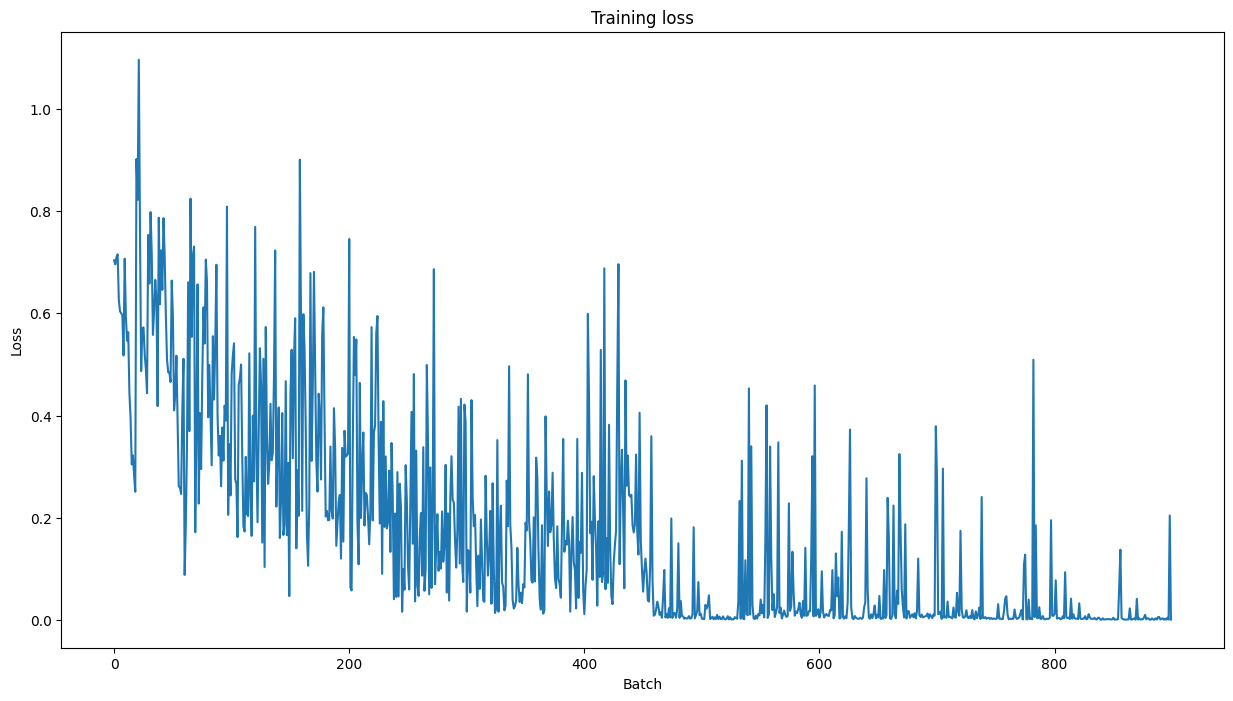

In [25]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##Predição e Avaliação via Holdout

Agora carregaremos o conjunto de dados de validação e prepararemos as entradas assim como fizemos com o conjunto de treinamento. Em seguida, avaliaremos as previsões usando AUC

In [26]:
test = imdb_dataset(test=True)

In [27]:
df_train = df
df = pd.DataFrame.from_records(map(lambda x: (x['sentiment'], x['text']), test), columns=['sentiment', 'text']).sample(2000)
df['sentiment'] = df.sentiment.map({'pos':1,'neg':0})

In [28]:
df.head()

,sentiment,text
20416,0,If you thought this is the french The Mummy an...
7664,1,It is to typical of people complaining about s...
11791,1,"Fantastic series, one of my few favorites (Mia..."
11324,1,"Charlie Wilson (Tom Hanks) is a hard-partying,..."
18944,0,This movie has too many things going on. Anoth...


In [29]:
df.sentiment.value_counts()

1    1010
0     990
Name: sentiment, dtype: int64

In [30]:
# Create sentence and label lists
sentences = df.text.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.sentiment.values
tokenized_texts = [tokenize_and_trim(sent) for sent in sentences]


# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [31]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)


In [32]:
from functools import reduce

In [33]:
scores = reduce(lambda x,y: x+y,[list(map(np.argmax,p)) for p in predictions])

In [34]:
labels = reduce(lambda x,y: list(x) + list(y), true_labels)

In [35]:
from sklearn.metrics import roc_auc_score

In [36]:
auc = roc_auc_score(labels, scores, average = None)

In [37]:
auc

0.8932643264326432

Boaaaa! Em pouco tempo, e sem fazer nenhum ajuste de hiperparâmetros (ajustando a taxa de aprendizado, épocas, tamanho do lote, propriedades do ADAM, etc.), conseguimos obter uma boa pontuação.

É de interesse mencionar também que não treinamos em todo o conjunto de dados de treinamento, mas reservamos uma parte dele como nosso conjunto de validação para legibilidade do código.



## Conclusão

Este treinamento visou demonstrar que com um modelo BERT pré-treinado você pode criar de forma rápida e eficaz um modelo de alta qualidade com mínimo esforço e tempo de treinamento usando a interface pytorch, independentemente da tarefa específica de PNL na qual você está interessado.

Agradecimentos ao Google pela disponibilização do modelo aqui utilizado.